# Creating a Convolutional Neural Network (CNN) to Categorize Health of Tomato Leaves

## Tyler Southworth

In this tutorial we will be creating a basic CNN from scratch with the goal of categorizing images of tomato leaves based on their health. This dataset is widely used in research and easily accessible and understandable.

This documentation serves as a brief and simple guide to the underlying deep learning concept of Convolutional Neural Networks. This tutorial utilizes leaf images to classify plant health and diagnose specific plant diseases in an effort to combat public health decline and economic loss brought on by crop loss (Marzougui et al. 2020; Shrestha et al. 2020; Yadhav et al. 2020).


The dataset can be found [here](https://www.kaggle.com/datasets/cookiefinder/tomato-disease-multiple-sources?resource=download). We are specifically using the data from folders 'Late_blight', 'Leaf_Mold', and 'healthy'. 

Do not download the data from this source, I have provided the data below and the files located at this link are much larger than what we will be using.



In [1]:
#@title Import Necessary Packages and Version Numbers
import matplotlib
import matplotlib.pyplot as plt
import skimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import imutils
from imutils import paths
from sklearn.utils.fixes import sklearn
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input, layers, Model
from tensorflow.keras.utils import to_categorical
import os
import random

### Version Information

This notebook was contstructed using the following package versions:

- matplotlib version: 3.2.2
- skimage version: 0.18.3
- imutils version: 0.5.4
- sklearn version: 1.0.2
- numpy version: 1.21.6
- OpenCV version: 4.6.0
- TensorFlow version: 2.9.2
- Keras version: 2.9.0

# The Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Obtaining the datasets

The folder titled 'Tomato_Images' should be in a shared folder with this notebook, which should now be located in your Google Drive.

To use this dataset, you will first gain access to folders within your Google Drive by mounting this Notebook to your Drive. 

To mount:

1. Click the folder icon on the left side of this screen
2. Click the third icon under files, which says 'Mount Drive' when hovered over
3. The notebook will generate a cell of code and notify you to run the cell in order to mount
4. You will have to grant permission for the notebook to access your Drive

After mounting, you will see the directory update and show a new folder named 'drive'. Here you can find all the contents of your Google Drive. 

Navigate to the folder in which you have stored the Tomato folder and open it. 

In the cell below, replace the existing file paths with the path to each corresponding file in your own Drive. You can easily get paths by right clicking each folder and selecting 'Copy path'.

In [3]:
healthyPath = list(paths.list_images('/paste/healthy_images/path/here'))
blightPath = list(paths.list_images('/paste/blight_images/path/here'))
moldPath = list(paths.list_images('/paste/mold_images/path/here'))

## Formatting the Data

We will want to change the size of our image. The size, and therefore detail in an image, has great effect on the time it takes to train our model. You may find that changing the size of the image and running the model several times with various image sizes beneficial in understanding the effect image size has on time and performance. By setting the size to a variable here, we will save ourselves some hassle if we decide to play around with the model using different image sizes.

Change the value of the variable here to resize the image. You will only have to update it in this one line of code for for change it in the entire notebook.

In [4]:
newSize = 50

We now need to load our images from the folders and define their classifications. 

Our three classifications for the leaves are 'healthy', 'blight', and 'mold'. We will save these classifications to the variable 'cats' (short for categories).



In [5]:
cats = ['healthy', 'blight', 'mold']

Now we need to add all of our images to one location in code. To do this, we will utilize the file paths we defined earlier as well as functions from a package called OpenCV. OpenCV is a useful tool for computer vision problems. We imported this package earlier, and if you are curious you may find its documentation [here](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html).

We will use a for loop to iterate through all the images using their file paths, resize the images using our newSize variable from earlier, and append each resized image to a list.

For a helpful guide on reisizing images using OpenCV, you can follow this [link](https://www.geeksforgeeks.org/image-resizing-using-opencv-python/).

In [6]:
#this for loop is adapted from: "Face mask image classification using CNN in Google Colab" https://muralimahadeva.medium.com/face-mask-image-classification-using-cnn-in-google-colab-5c61c8419068#dcdd
#allTomato will contain all of the images
allTomato = []
#we create a path variable that contains all the image paths of our data
allPath = healthyPath + blightPath + moldPath
#we now build the for loop to iterate through all of our images, resize, and append to a new list
for location in allPath:
  tomatoArray = cv2.imread(location)
  #take note that the variable we defined earlier for the image size is being used here. (newSize, newSize) = (height, width)
  resizedTomato = cv2.resize(tomatoArray, (newSize, newSize))
  allTomato.append(resizedTomato)

To better understand the difference in image quality resizing makes, we will plot an original image alongside a resized image. To accomplish this, we will make use of functions from matplotlib. You can find documentation on the pyplot function [here](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html), and you will also find a helpful guide for using this tool to plot image panels located [here](https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/).

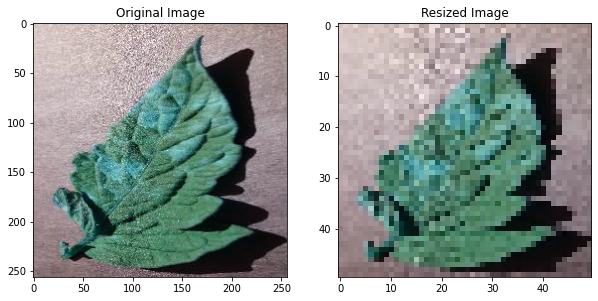

In [7]:
#visualizing the resizing of images and quality difference to the naked eye
#creating this plot was adapted from: "How to Display Multiple Images in One Figure Correctly in Matplotlib?" https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/
#naming and setting the side of our plot
comparison = plt.figure(figsize=(10, 10))
#setting the dimensions of our image panel. since we are only plotting two images, we will put them side by side (1 row, 2 columns)
#here we are adding the original image to row 1, column 2, position 1
comparison.add_subplot(1, 2, 1)
#we source the image from the original tomatoArray
plt.imshow(tomatoArray)
#adding a title to the image
plt.title('Original Image')

#now we add the second image to row 1, column 2, position 2
comparison.add_subplot(1, 2, 2)
plt.imshow(resizedTomato)
plt.title('Resized Image')

#viewing our panel
comparison.show()

We will now create a NumPy array of all the images contained in allTomato, create our labels, and view the shape of our arrays.

In order for our model to work, we will assign numeric labels for each image category so that:


*   healthy: 0
*   blight: 1
*   mold: 2



In [9]:
#y is the output (classification, either 0, 1, or 2) and X is the input (all of our tomato images saved to allTomato)
X = np.array(allTomato)
y = np.array(([0] * len(healthyPath)) + [1] * len(blightPath) + [2] * len(moldPath))
#there should be 100 of each classification
print('There are ' + str(len(y)) + ' total labels.')
#there should be 300 images of size defined by our newSize variable with 3 RGB channels
print('We have 300 images of the shape (newSize x newSize) with 3 RGB channels, confirmed by checking the shape of X: ' + str(X.shape))

There are 300 total labels.
We have 300 images of the shape (newSize x newSize) with 3 RGB channels, confirmed by checking the shape of X: (300, 50, 50, 3)


We can now visualize the working data after it has been resized, labeled, and converted to array.

Text(0.5, 0, 'mold')

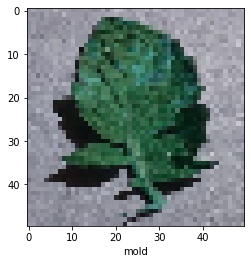

In [13]:
#prints random image from our list of image arrays
ranIndex = random.randint(0, 299)
plt.imshow(X[ranIndex])
plt.xlabel(cats[y[ranIndex]])

The last thing we have to do to our data before applying it to a model is to split it into training and testing data. To do this, we will utilize the train_test_split function from scikit learn. This is a very common function used in machine learning and is worth familiarizing with via the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

We will split our images stored in variable X as well as our labels in y such that 80% of the data is used for training and 20% will be used in testing. 

After the following cell, we will have four new key variables:


*   X_train and X_test: contains the images for training and testing datasets respectively
*   y_train and y_test: contains the labels for training and testing datasets respectively


In [14]:
#splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

We now have to one-hot encode our labels. This is important for when we pass them to our model. By one-hot encoding we are essentially translating each single classifying integer (0, 1, 2) to a matrix that represents each value. A helpful guide on this process can be found [here](https://www.geeksforgeeks.org/python-keras-keras-utils-to_categorical/).

After one-hot encoding:



*   healthy (0) becomes [1, 0, 0]
*   blight (1) becomes [0, 1, 0]
*   mold (2) becomes [0, 0, 1]



In [15]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

Let's look at the shape of all of our data structures to ensure everything is in order.

We expect the training image set to have 240 images (80% of 300) of the specified size (variable newSize) which is by default 50, and 3 channels. There should also be 240 training labels with three columns and three possible values.

Likewise, we expect the testing image set to have 60 images (20% of 300) and have the same size and number of channels as the training set. The testing labels should number 60 and have the same dimensions as the training labels.

In [16]:
#these will now show that the data has been split up successfully
print('Training images and labels:')
print(X_train.shape)
print(y_train.shape)
print('Testing images and labels:')
print(X_test.shape)
print(y_test.shape)

Training images and labels:
(240, 50, 50, 3)
(240, 3)
Testing images and labels:
(60, 50, 50, 3)
(60, 3)


# The Model

## Building the CNN
Now that we have our training and testing datasets, we need to build the model that we will use. 

There are several very important components to a CNN model. We will walk through each one so that we can understand how the model works and how we can alter its performance based on its components.

This model is composed of layers that do various things. The first layer is our input layer and is responsible for receiving the data. In this model, we compile the input with a convolutional layer.

Each convolutional layer essentially applies a filter to the image that emphasizes significant areas of the image. In our case, the goal is for the convolutional layers to highlight areas of the leaves where there is blight or mold, and recognize the absense of these areas on healthy leaves. Additional explanation can be found [here](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/).

Each convolutional layer is followed by a [pooling layer](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) that generalizes the features (afflicted area of the leaf) so that the model is not thrown off by slight variations in the features. This allows the model to be better at identifying features across image samples. Convolution layers take several [parameters](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), including the activation function. In this tutorial, we will be using the Rectified Linear Unit activation function [(ReLU)](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/).

We will also [rescale](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) the image for consistency. After several layers of convolution and pooling, we will flatten the images to 1D so that they can pass to the final layers of our model.

The final layers of our model are called [dense](https://analyticsindiamag.com/a-complete-understanding-of-dense-layers-in-neural-networks/) layers, and they may only receive 1D input. The dense layers are responsible with providing us the classification of our images. As such, you will see the last dense layer have an output value of 3 since we have three potential classifications.





In [17]:
#initiating model. additional info: "The Sequential model" https://keras.io/guides/sequential_model/
#model adapted from: "Convolutional Neural Network (CNN)" https://www.tensorflow.org/tutorials/images/cnn
model = models.Sequential()

#creating our input layer followed by a pooling layer
#each convolution layer (layers.Conv2D) is followed by a pooling layer
#you will note that we are using the variable newSize here again, as we want to make sure the model expects the input image size we are providing it
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (newSize, newSize, 3)))
model.add(layers.MaxPooling2D(2, 2))

#normalizing the pixels, ensuring each value is within the range of 0 to 1
model.add(layers.experimental.preprocessing.Rescaling(1./255))

#adding additional layers to the feature learning portion of the model
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

#flattening the output to 1D to pass to dense layers
model.add(layers.Flatten())

#adding dense layers for providing output
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
#we want the final layer to have an output of 3, because that is the number of possible classifications of the images
model.add(layers.Dense(3, activation = 'softmax'))

#showing architecture of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 rescaling (Rescaling)       (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         7

From the output of the cell above we see that each convolutional layer provides a number of [parameters](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d) as seen in the final column. This is essentially the number of features that layer is able to learn from the given input. Note that the output value for each layer is directly related to the number of parameters, as a higher output allows for more parameters to be learned.

## Compiling the model

In order to use the model, we must compile it. The compile function is from Keras, and has extensive [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model) for compiling and fitting. We pass three arguments into the compile function:



1.   Optimizer: the optimizer class. There are many that are commonly used and here we pass the 'adam' algorithm. You may find information on optimizers as a whole and links to specific optimizers [here](https://keras.io/api/optimizers/).
2.   Loss: this is the function by which we will calculate difference between the expected output and the observed output. Ideally our model would be very good at predicting image classifications and have a low [loss function](https://towardsdatascience.com/loss-functions-and-their-use-in-neural-networks-a470e703f1e9#:~:text=A%20loss%20function%20is%20a,the%20predicted%20and%20target%20outputs.).
3.   Metrics: one or many metrics may be passed. Any passed metrics will be recorded as the model is trained. These are helpful for visualizing the performance of our model. For this example, we are most interested in how well our model is predicting the health of the leaves, so we will keep record of accuracy. 



In [18]:
#compiling model
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

## Applying the model

Finally we will bring the data and the model together. Below we create a variable named history which will hold the fit of our model.

We use the function model.fit and pass it several parameters:



1.   The training images and the training labels for the model to 'learn' on.
2.   The number of epochs, or iterations, that we want the model to perform. Having more epochs allows the model to perform better over time.
3.   The data to which the fit model will be applied to, which is our testing data.

The ouput of the following cell will update as training continues and it will report five things:



1.   The time it took for the epoch from start to finish
2.   The 'loss' and 'accuracy', which is the loss and accuracy during training
3.   The 'val_loss' and 'val_accuracy', which is the loss and accuracy during testing





In [21]:
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test))

Epoch 1/20
8/8 [==============================] - 1s 157ms/step - loss: 0.1188 - accuracy: 0.9667 - val_loss: 0.7745 - val_accuracy: 0.8000
Epoch 2/20
8/8 [==============================] - 1s 149ms/step - loss: 0.1808 - accuracy: 0.9250 - val_loss: 0.7361 - val_accuracy: 0.8000
Epoch 3/20
8/8 [==============================] - 1s 148ms/step - loss: 0.2419 - accuracy: 0.9000 - val_loss: 0.5487 - val_accuracy: 0.8667
Epoch 4/20
8/8 [==============================] - 1s 151ms/step - loss: 0.2877 - accuracy: 0.8917 - val_loss: 2.1055 - val_accuracy: 0.5833
Epoch 5/20
8/8 [==============================] - 1s 146ms/step - loss: 0.1915 - accuracy: 0.9292 - val_loss: 0.6143 - val_accuracy: 0.8000
Epoch 6/20
8/8 [==============================] - 1s 146ms/step - loss: 0.1339 - accuracy: 0.9542 - val_loss: 0.7590 - val_accuracy: 0.7833
Epoch 7/20
8/8 [==============================] - 1s 143ms/step - loss: 0.0812 - accuracy: 0.9750 - val_loss: 0.5645 - val_accuracy: 0.8833
Epoch 8/20
8/8 [====

We see that over time during training, our model reduced loss and increased accuracy. The decrease in loss shows that the discrepency between the predicted and observed classification improved (minimized) over time, and the accuracy shows that the correct classification was made more frequently as training progressed. 

There is a similar trend in the testing metrics as well, and depending on the run, testing metrics may result in slightly better or slightly worse performance than training. Overall, both metrics stay close to each other and provide a good indication that training was beneficial to the performance of this model. 

We have built a strong model given that the correct classification is achieved 85% of the time (result may vary per run). 

Altering the parameters such as the output of each layers, image size (remember our variable newSize), and number of epochs may result in different levels of performance. Changing these values and running the model anew will better reveal the dynamics between parameters and performance.

## Visualizing Model Performance

To display the performance of our model over time we will plot the accuracy and loss during training and testing.

The code for generating these plots can be found in the [CNN tutorial](https://www.tensorflow.org/tutorials/images/cnn) from Tensorflow. 

In the plot below we can see that validation accuracy is lower than training accuracy in the end, but still relatively high. Additionally, we can clearly see that over epochs accuracy has an overall increase in value in both training and testing.

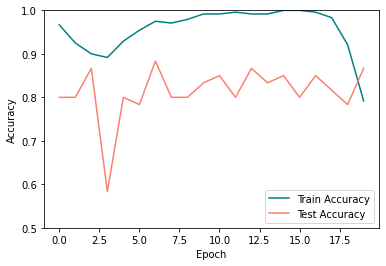

In [24]:
# Plot training (teal) and testing (pink) accuracy:
plt.plot(history.history['accuracy'], label='Train Accuracy', color = 'teal')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy', color = 'salmon')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We can also see similar variation in loss throughout epochs and a lower training loss in the end. The difference between training and testing losses is not significantly high, and loss decreases over time which indicates that our model is improving significantly during training.

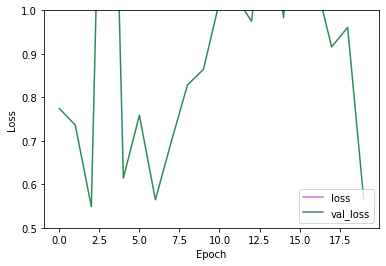

In [25]:
# Plot training (purple) and testing (green) accuracy:
plt.plot(history.history['loss'], label='loss', color = 'orchid')
plt.plot(history.history['val_loss'], label = 'val_loss', color = 'seagreen')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#Conclusion

This tutorial has demonstrated how to import and format data from Google Drive and build a CNN to predict disease in plant leaves. While accuracy and loss will vary by run, this model generally performs at an accuracy of 90% or higher with acceptable loss. The links within this tutorial provide supplemental information on concepts related to CNNs as well as the code used to build this model.

## References

Papers and articles referenced in this tutorial may be found in the .bib file named 'CNN_References.bib' in the 'Hops_CNN_Project' repository.